### Load Utility Functions

In [1]:
from utility import *

### Load Dataframe

In [2]:
df = pd.read_csv('feature_vect')
df  = df[df.Manufacturer != 'PHILIPS']

In [3]:
# Compute TSNE clustering
xVal, yVal = tsne_cluster(df.iloc[:,:-2])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1252 samples in 0.281s...
[t-SNE] Computed neighbors for 1252 samples in 4.715s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1252
[t-SNE] Computed conditional probabilities for sample 1252 / 1252
[t-SNE] Mean sigma: 0.998863
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.592720
[t-SNE] KL divergence after 6900 iterations: 0.974108


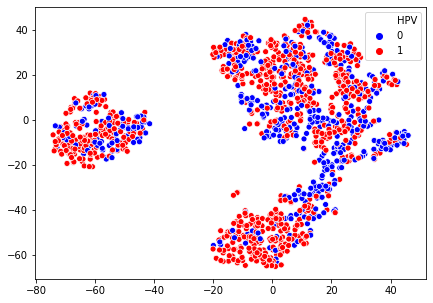

In [4]:
# Plot TSNE clusters
plt.figure(figsize=(7,5))
sns.scatterplot(x=xVal, y=yVal,hue = df['HPV'],palette=['blue','red'])
ax = plt.gca()
# plt.savefig('/results/Figure3(left).png')

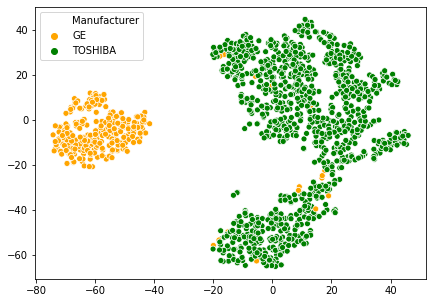

In [5]:
# Plot TSNE clusters
plt.figure(figsize=(7,5))
sns.scatterplot(x=xVal, y=yVal,hue = df['Manufacturer'],palette=['orange','green'])
ax = plt.gca()
# plt.savefig('/results/Figure3.jpg')

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.utils.random import sample_without_replacement as rsm

ge_ge_1 = pd.DataFrame(columns=['fpr','tpr','auc'])
ge_tosh_1 = pd.DataFrame(columns=['fpr','tpr','auc'])
ge_mix_1 = pd.DataFrame(columns=['fpr','tpr','auc'])
tosh_tosh_1 = pd.DataFrame(columns=['fpr','tpr','auc'])
tosh_ge_1 = pd.DataFrame(columns=['fpr','tpr','auc'])
tosh_mix_1 = pd.DataFrame(columns=['fpr','tpr','auc'])
mix_mix_1 = pd.DataFrame(columns=['fpr','tpr','auc'])
mix_tosh_1 = pd.DataFrame(columns=['fpr','tpr','auc'])
mix_ge_1 = pd.DataFrame(columns=['fpr','tpr','auc'])

ge_ge_2 = pd.DataFrame(columns=['fpr','tpr','auc'])
ge_tosh_2 = pd.DataFrame(columns=['fpr','tpr','auc'])
ge_mix_2 = pd.DataFrame(columns=['fpr','tpr','auc'])
tosh_tosh_2 = pd.DataFrame(columns=['fpr','tpr','auc'])
tosh_ge_2 = pd.DataFrame(columns=['fpr','tpr','auc'])
tosh_mix_2 = pd.DataFrame(columns=['fpr','tpr','auc'])
mix_mix_2 = pd.DataFrame(columns=['fpr','tpr','auc'])
mix_tosh_2 = pd.DataFrame(columns=['fpr','tpr','auc'])
mix_ge_2 = pd.DataFrame(columns=['fpr','tpr','auc'])


robust_filter = []
robust_feature = []

feat_g_mrmr_1 = []
feat_t_mrmr_1 = []
feat_mix_mrmr_1 = []

feat_g_mrmr_2 = []
feat_t_mrmr_2 = []
feat_mix_mrmr_2 = []

fil_g_mrmr_1 = []
fil_t_mrmr_1 = []
fil_mix_mrmr_1 = []

fil_g_mrmr_2 = []
fil_t_mrmr_2 = []
fil_mix_mrmr_2 = []


for i in range(2):  
    
    print(f'round {i} is started!')

    
    GEneg = df[(df.Manufacturer == 'GE') & (df.HPV == 0)]
    GEpos = df[(df.Manufacturer == 'GE') & (df.HPV == 1)]
    train_gneg, test_gneg = train_test_split (GEneg.iloc[rsm(len(GEneg),len(GEneg)*0.8)], test_size=0.25)
    train_gpos, test_gpos = train_test_split (GEpos.iloc[rsm(len(GEpos),len(GEneg)*0.8)], test_size=0.25)
    train_g = pd.concat([train_gneg,train_gpos])
    test_g = pd.concat([test_gneg,test_gpos])
    
    Toshibaneg = df[(df.Manufacturer == 'TOSHIBA') & (df.HPV == 0)]
    Toshibapos = df[(df.Manufacturer == 'TOSHIBA') & (df.HPV == 1)]
    train_tneg, test_tneg = train_test_split (Toshibaneg.iloc[rsm(len(Toshibaneg),len(GEneg)*0.8)], test_size=0.25)
    train_tpos, test_tpos = train_test_split (Toshibapos.iloc[rsm(len(Toshibapos),len(GEneg)*0.8)], test_size=0.25)
    train_t = pd.concat([train_tneg,train_tpos])
    test_t = pd.concat([test_tneg,test_tpos])
    
    

    train_mneg = pd.concat([train_gneg.sample(int(np.round(train_gneg.shape[0]/2))),
                            train_tneg.sample(int(np.round(train_tneg.shape[0]/2)))])
    train_mpos = pd.concat([train_gpos.sample(int(np.round(train_gpos.shape[0]/2))),
                            train_tpos.sample(int(np.round(train_tpos.shape[0]/2)))])
    train_mix = pd.concat([train_mneg,train_mpos])

    
    test_mneg = pd.concat([test_gneg.sample(int(np.round(test_gneg.shape[0]/2))),
                 test_tneg.sample(int(np.round(test_tneg.shape[0]/2)))])
    test_mpos = pd.concat([test_gpos.sample(int(np.round(test_gpos.shape[0]/2))),
                 test_tpos.sample(int(np.round(test_tpos.shape[0]/2)))]) 
    test_mix = pd.concat([test_mneg,test_mpos])
    
    
    
    
    
    #Robust features are selected based on wilcoxon rank-sum test and p-value was corrected using Bonferoni
    print('Wilcoxon rank-sum test ...')  
    
    f = RankSumTest2(train_g[train_g.columns[:-2]],train_t[train_t.columns[:-2]])
    f['pval'] = multi.multipletests(f['pval'], alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[1]
    
    robust_feat = f.loc[f['pval']>0.05, 'feat']
    print('Number of robust features: ',len(robust_feat))
    
    
    robust_filter.append(filter_class(robust_feat)[1])
    robust_feature.append(feature_class(robust_feat)[1])


 
    # Training data (GE) was fed into mRMR feature selection after removing the Manufacturer column
    feat_g_1 = mrmr_feat (train_g.iloc[:,:-1],100)
    feat_g_mrmr_1.append(feature_class(feat_g_1)[1])
    fil_g_mrmr_1.append(filter_class(feat_g_1)[1])
    
    
    # To run mRMR over the robust features comment the above line and uncomment the below one
    feat_g_2 = mrmr_feat (train_g[robust_feat],100)  
    feat_g_mrmr_2.append(feature_class(feat_g_2)[1])
    fil_g_mrmr_2.append(filter_class(feat_g_2)[1])


                          
    # Training data (Toshiba) was fed into mRMR feature selection after removing the Manufacturer column                          
    feat_t_1 = mrmr_feat(train_t.iloc[:,:-1],100)
    feat_t_mrmr_1.append(feature_class(feat_t_1)[1])
    fil_t_mrmr_1.append(filter_class(feat_t_1)[1])
    
# To run mRMR over the robust features comment the above line and uncomment the below one
    feat_t_2 = mrmr_feat (train_t[robust_feat],100)                            
    feat_t_mrmr_2.append(feature_class(feat_t_2)[1])
    fil_t_mrmr_2.append(filter_class(feat_t_2)[1])


    # Training data (Toshiba) was fed into mRMR feature selection after removing the Manufacturer column                          
    feat_mix_1 = mrmr_feat (train_mix.iloc[:,:-1],100)
    feat_mix_mrmr_1.append(feature_class(feat_mix_1)[1])
    fil_mix_mrmr_1.append(filter_class(feat_mix_1)[1])
    
    # To run mRMR over the robust features comment the above line and uncomment the below one
    feat_mix_2 = mrmr_feat (train_mix[robust_feat],100)                      
    feat_mix_mrmr_2.append(feature_class(feat_mix_2)[1])
    fil_mix_mrmr_2.append(filter_class(feat_mix_2)[1])

                          
    # Training
    print('Training(all features) ...')
    model_g_1   = train_model(train_g[feat_g_1],train_g['HPV'])
    model_t_1  = train_model(train_t[feat_t_1],train_t['HPV'])  
    model_mix_1 = train_model(train_mix[feat_mix_1],train_mix['HPV'])
    
    print('Training(robust features) ...')
    model_g_2   = train_model(train_g[feat_g_2],train_g['HPV'])
    model_t_2  = train_model(train_t[feat_t_2],train_t['HPV'])  
    model_mix_2 = train_model(train_mix[feat_mix_2],train_mix['HPV']) 
    
    
    
    # Testing
    print('Testing ...')
   

    fpr,tpr,auc = test_model(model_g_1, test_g[feat_g_1],test_g['HPV'])
    ge_ge_1 = ge_ge_1.append({'fpr':fpr,'tpr':tpr,'auc':auc}, ignore_index=True)    
    fpr,tpr,auc = test_model(model_g_2, test_g[feat_g_2],test_g['HPV'])
    ge_ge_2 = ge_ge_2.append({'fpr':fpr,'tpr':tpr,'auc':auc}, ignore_index=True)

    
    fpr,tpr,auc  = test_model(model_g_1, test_t[feat_g_1],test_t['HPV'])
    ge_tosh_1 = ge_tosh_1.append({'fpr':fpr,'tpr':tpr,'auc':auc}, ignore_index=True)    
    fpr,tpr,auc  = test_model(model_g_2, test_t[feat_g_2],test_t['HPV'])
    ge_tosh_2 = ge_tosh_2.append({'fpr':fpr,'tpr':tpr,'auc':auc}, ignore_index=True)

    
    fpr,tpr,auc = test_model(model_g_1, test_mix[feat_g_1],test_mix['HPV'])
    ge_mix_1 = ge_mix_1.append({'fpr':fpr,'tpr':tpr,'auc':auc}, ignore_index=True)
    fpr,tpr,auc = test_model(model_g_2, test_mix[feat_g_2],test_mix['HPV'])
    ge_mix_2 = ge_mix_2.append({'fpr':fpr,'tpr':tpr,'auc':auc}, ignore_index=True)

    
    fpr,tpr,auc = test_model(model_t_1, test_g[feat_t_1],test_g['HPV'])
    tosh_ge_1 = tosh_ge_1.append({'fpr':fpr,'tpr':tpr,'auc':auc}, ignore_index=True)
    fpr,tpr,auc = test_model(model_t_2, test_g[feat_t_2],test_g['HPV'])
    tosh_ge_2 = tosh_ge_2.append({'fpr':fpr,'tpr':tpr,'auc':auc}, ignore_index=True)
 
    
    fpr,tpr,auc = test_model(model_t_1, test_t[feat_t_1],test_t['HPV'])
    tosh_tosh_1 = tosh_tosh_1.append({'fpr':fpr,'tpr':tpr,'auc':auc}, ignore_index=True)
    fpr,tpr,auc = test_model(model_t_2, test_t[feat_t_2],test_t['HPV'])
    tosh_tosh_2 = tosh_tosh_2.append({'fpr':fpr,'tpr':tpr,'auc':auc}, ignore_index=True)
    
    fpr,tpr,auc = test_model(model_t_1, test_mix[feat_t_1],test_mix['HPV'])
    tosh_mix_1 = tosh_mix_1.append({'fpr':fpr,'tpr':tpr,'auc':auc}, ignore_index=True)
    fpr,tpr,auc = test_model(model_t_2, test_mix[feat_t_2],test_mix['HPV'])
    tosh_mix_2 = tosh_mix_2.append({'fpr':fpr,'tpr':tpr,'auc':auc}, ignore_index=True)
    
    fpr,tpr,auc = test_model(model_mix_1, test_g[feat_mix_1],test_g['HPV'])
    mix_ge_1 = mix_ge_1.append({'fpr':fpr,'tpr':tpr,'auc':auc}, ignore_index=True)
    fpr,tpr,auc = test_model(model_mix_2, test_g[feat_mix_2],test_g['HPV'])
    mix_ge_2 = mix_ge_2.append({'fpr':fpr,'tpr':tpr,'auc':auc}, ignore_index=True)
    
    fpr,tpr,auc = test_model(model_mix_1, test_t[feat_mix_1],test_t['HPV'])
    mix_tosh_1 = mix_tosh_1.append({'fpr':fpr,'tpr':tpr,'auc':auc}, ignore_index=True)
    fpr,tpr,auc = test_model(model_mix_2, test_t[feat_mix_2],test_t['HPV'])
    mix_tosh_2 = mix_tosh_2.append({'fpr':fpr,'tpr':tpr,'auc':auc}, ignore_index=True)
 
    fpr,tpr,auc = test_model(model_mix_1, test_mix[feat_mix_1],test_mix['HPV'])
    mix_mix_1 = mix_mix_1.append({'fpr':fpr,'tpr':tpr,'auc':auc}, ignore_index=True)
    fpr,tpr,auc = test_model(model_mix_2, test_mix[feat_mix_2],test_mix['HPV'])
    mix_mix_2 = mix_mix_2.append({'fpr':fpr,'tpr':tpr,'auc':auc}, ignore_index=True)

    print(f' round {i} is completed!')
    print('------------------')
print('finished!')

round 0 is started!
Wilcoxon rank-sum test ...
Number of robust features:  655
Training(all features) ...
Training(robust features) ...
Testing ...
 round 0 is completed!
------------------
round 1 is started!
Wilcoxon rank-sum test ...
Number of robust features:  592


C:\Users\iran\Anaconda3\envs\py38\lib\site-packages\pymrmre\MrmreFilter.py:159: RuntimeWarning: invalid value encountered in less
  mi_dropped = np.where(-.5 * np.log(1 - np.square(self._mi_matrix[:, target_index])) < mi_threshold)
C:\Users\iran\Anaconda3\envs\py38\lib\site-packages\pymrmre\MrmreFilter.py:158: RuntimeWarning: invalid value encountered in greater
  causality_dropped = np.where(np.array(self._causality_list.loc[target_index]) > causality_threshold)


Training(all features) ...
Training(robust features) ...
Testing ...
 round 1 is completed!
------------------
finished!


In [8]:
feature = pd.DataFrame(robust_feature, columns = feature_class(f.loc[f['pval']>0.05, 'feat'])[0]).T

Figure5:(left)Proportion of robust features to the total number of features in each class


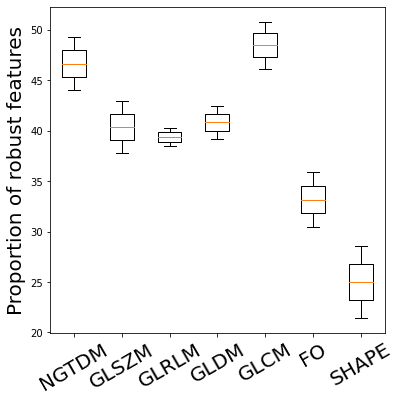

In [9]:
print('Figure5:(left)Proportion of robust features to the total number of features in each class')
boxplotting_1(feature,'','Proportion of robust features',figsize = (6,6))
# plt.savefig('/results/Figure(left).jpg')

Figure5:(Right)Proportion of robust features to the total number of robust features


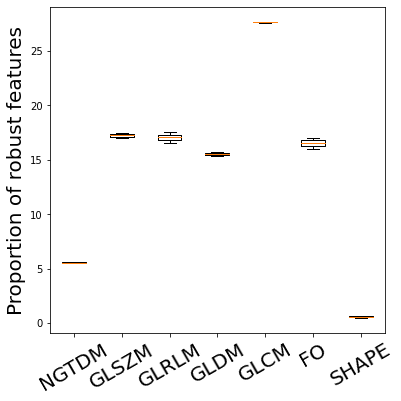

In [10]:
print('Figure5:(Right)Proportion of robust features to the total number of robust features')
boxplotting_2(feature,'','Proportion of robust features',figsize = (6,6))
# plt.savefig('/results/Figure5(Right).jpg')

Figure 6: The proportion of robust first order features with different image filters.
Values were normalized to the total number of features in each category.


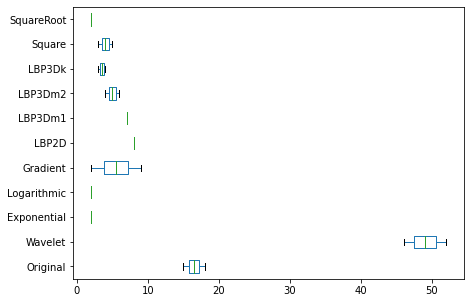

In [11]:
print('Figure 6: The proportion of robust first order features with different image filters.')
print('Values were normalized to the total number of features in each category.')

kwarg = {'grid':False, 'fontsize':10,'vert':False, 'figsize':(7,5), 'showfliers':False}

feature.iloc[1:12].T.boxplot(**kwarg)
plt.yticks([1,2,3,4,5,6,7,8,9,10,11],['Original','Wavelet','Exponential','Logarithmic','Gradient',
                                         'LBP2D','LBP3Dm1','LBP3Dm2','LBP3Dk','Square', 'SquareRoot'])
plt.show()
# plt.savefig('/results/Figure6_FO.png')

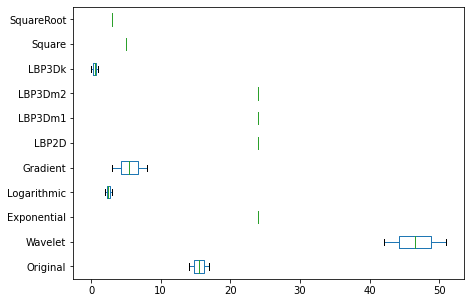

In [12]:
feature.iloc[12:23].T.boxplot(**kwarg)
plt.yticks([1,2,3,4,5,6,7,8,9,10,11],['Original','Wavelet','Exponential','Logarithmic','Gradient',
                                         'LBP2D','LBP3Dm1','LBP3Dm2','LBP3Dk','Square', 'SquareRoot'])
plt.show()
# plt.savefig('/results/Figure6_GLCM.png')

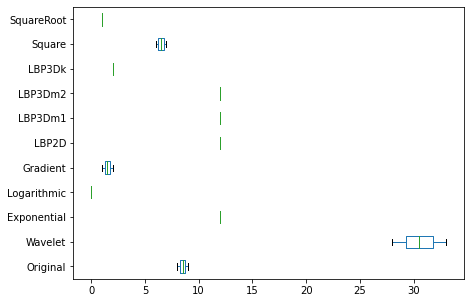

In [13]:
feature.iloc[23:34].T.boxplot(**kwarg)
plt.yticks([1,2,3,4,5,6,7,8,9,10,11],['Original','Wavelet','Exponential','Logarithmic','Gradient',
                                         'LBP2D','LBP3Dm1','LBP3Dm2','LBP3Dk','Square', 'SquareRoot'])
plt.show()
# plt.savefig('/results/Figure6_GLDM.png')

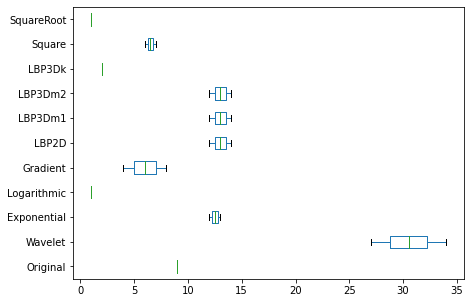

In [14]:
feature.iloc[34:45].T.boxplot(**kwarg)
plt.yticks([1,2,3,4,5,6,7,8,9,10,11],['Original','Wavelet','Exponential','Logarithmic','Gradient',
                                         'LBP2D','LBP3Dm1','LBP3Dm2','LBP3Dk','Square', 'SquareRoot'])
plt.show()
# plt.savefig('/results/Figure6_GLRLM.png')

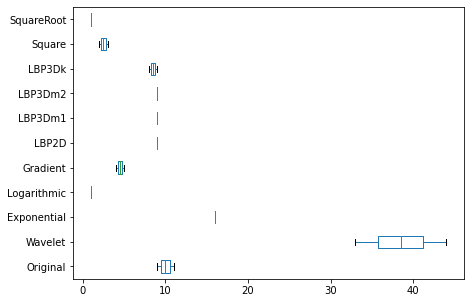

In [15]:
feature.iloc[45:56].T.boxplot(**kwarg)
plt.yticks([1,2,3,4,5,6,7,8,9,10,11],['Original','Wavelet','Exponential','Logarithmic','Gradient',
                                         'LBP2D','LBP3Dm1','LBP3Dm2','LBP3Dk','Square', 'SquareRoot'])
plt.show()
# plt.savefig('/results/Figure6_GLSZM.png')

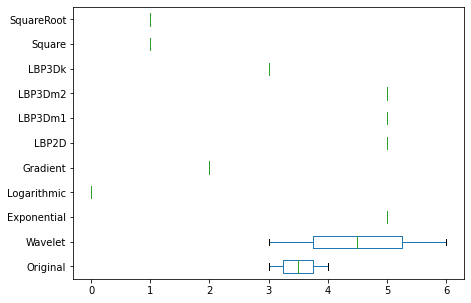

In [16]:
feature.iloc[56:].T.boxplot(**kwarg)
plt.yticks([1,2,3,4,5,6,7,8,9,10,11],['Original','Wavelet','Exponential','Logarithmic','Gradient',
                                     'LBP2D','LBP3Dm1','LBP3Dm2','LBP3Dk','Square', 'SquareRoot'])
plt.show()
# plt.savefig('/results/Figure6_NGTDM.png')

In [17]:
filters = pd.DataFrame(robust_filter, columns = filter_class(f.loc[f['pval']>0.05, 'feat'])[0])

Figure 7(Right): the proportion of robust features regarding preprocessing filters.


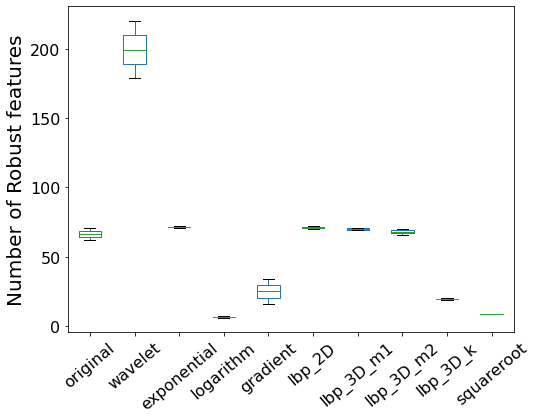

In [18]:
print('Figure 7(Right): the proportion of robust features regarding preprocessing filters.')
filters.boxplot(rot = 40,grid = False,fontsize = 16,figsize = (8,6), showfliers=False)
plt.ylabel('Number of Robust features', fontsize = 20)
plt.show()
# plt.savefig('/results/Figure7(Right).png')

Figure 7(left):the same data but numbers are normalized based on the number of features in that group.


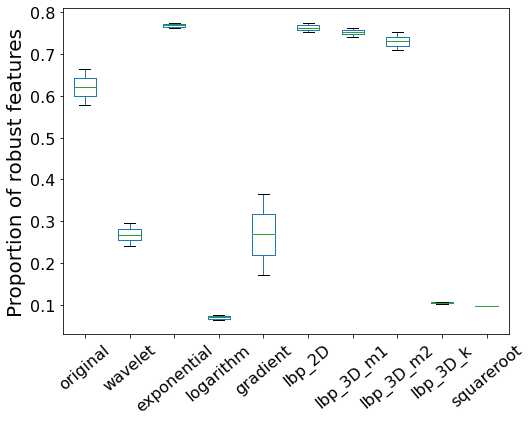

In [19]:
print('Figure 7(left):the same data but numbers are normalized based on the number of features in that group.')
(filters/feat_counter(df)).boxplot(rot = 40,grid = False,fontsize = 16,figsize = (8,6), showfliers=False)
plt.ylabel('Proportion of robust features', fontsize = 20)
plt.show()
# plt.savefig('/results/Figure7(Left).png')

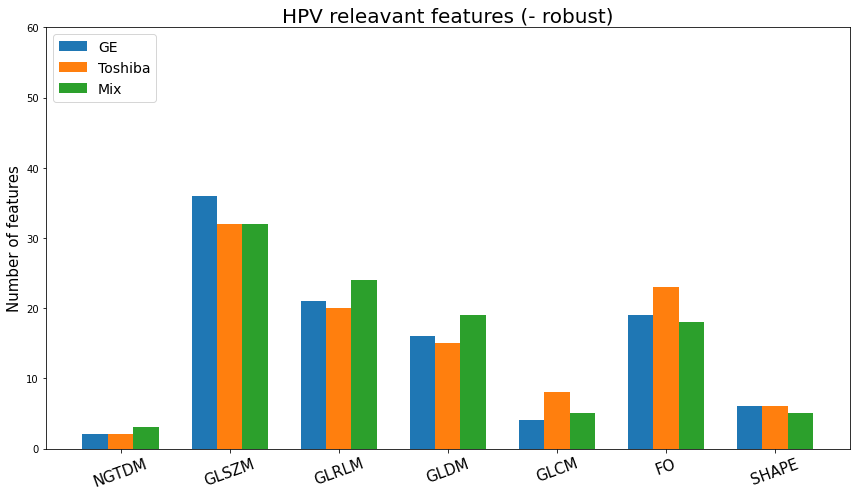

In [20]:

labels = ['NGTDM','GLSZM', 'GLRLM', 'GLDM', 'GLCM','FO','SHAPE']

ge = feat_values(feat_g_mrmr_1)
To = feat_values(feat_t_mrmr_1)
mi = feat_values(feat_mix_mrmr_1)

x = np.array([3,6,9,12,15,18,21])  # the label locations
width = 2.1  # the width of the bars

fig, ax = plt.subplots(figsize = (12,7))
rects1 = ax.bar(x - width/3, ge, width/3, label='GE')
rects2 = ax.bar(x , To, width/3, label='Toshiba')
rects3 = ax.bar(x + width/3, mi, width/3, label='Mix')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of features', fontsize = 15)
ax.set_title('HPV releavant features (- robust)',fontsize = 20)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize = 15, rotation = 20)
ax.legend(fontsize = 14, loc = 'upper left')
plt.ylim(0, 60)

fig.tight_layout()
plt.show()
# plt.savefig('/results/Figur8(Top).png')

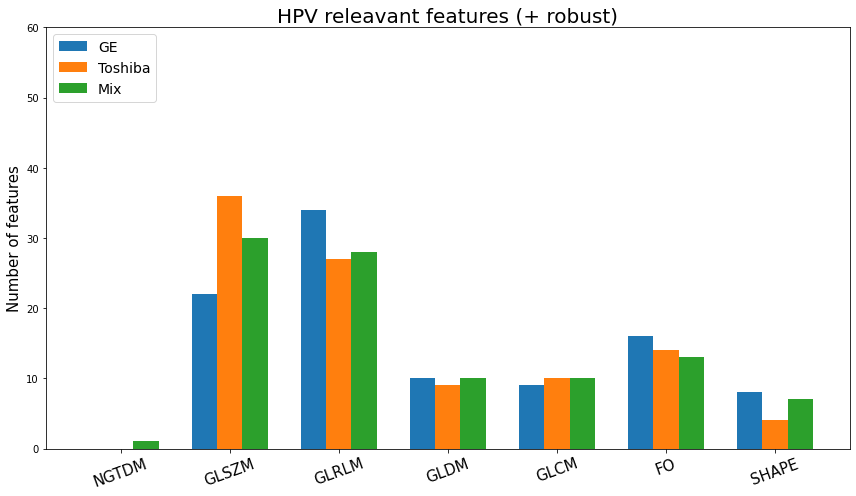

In [21]:
labels = ['NGTDM','GLSZM', 'GLRLM', 'GLDM', 'GLCM','FO','SHAPE']

ge = feat_values(feat_g_mrmr_2)
To = feat_values(feat_t_mrmr_2)
mi = feat_values(feat_mix_mrmr_2)

x = np.array([3,6,9,12,15,18,21])  # the label locations
width = 2.1  # the width of the bars

fig, ax = plt.subplots(figsize = (12,7))
rects1 = ax.bar(x - width/3, ge, width/3, label='GE')
rects2 = ax.bar(x , To, width/3, label='Toshiba')
rects3 = ax.bar(x + width/3, mi, width/3, label='Mix')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of features', fontsize = 15)
ax.set_title('HPV releavant features (+ robust)',fontsize = 20)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize = 15, rotation = 20)
ax.legend(fontsize = 14, loc = 'upper left')
plt.ylim(0, 60)

fig.tight_layout()
plt.show()
# plt.savefig('/results/Figur8(Bottom).png')

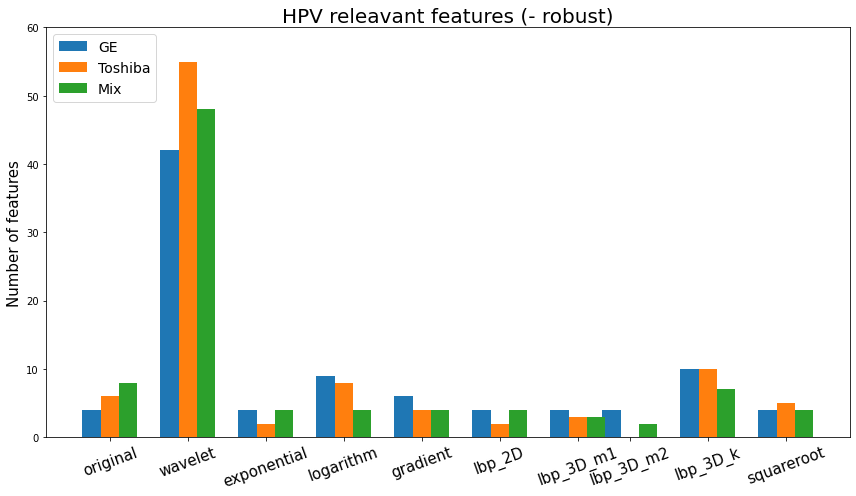

In [22]:
labels = ['original', 'wavelet', 'exponential', 'logarithm', 'gradient',
          'lbp_2D', 'lbp_3D_m1', 'lbp_3D_m2', 'lbp_3D_k', 'squareroot']

ge = filter_values(fil_g_mrmr_1)
To = filter_values(fil_t_mrmr_1)
mi = filter_values(fil_mix_mrmr_1)

x = np.array([3,6,9,12,15,18,21,23,26,29])  # the label locations
width = 2.1  # the width of the bars

fig, ax = plt.subplots(figsize = (12,7))
rects1 = ax.bar(x - width/3, ge, width/3, label='GE')
rects2 = ax.bar(x , To, width/3, label='Toshiba')
rects3 = ax.bar(x + width/3, mi, width/3, label='Mix')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of features', fontsize = 15)
ax.set_title('HPV releavant features (- robust)',fontsize = 20)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize = 15, rotation = 20)
ax.legend(fontsize = 14, loc = 'upper left')
plt.ylim(0, 60)
fig.tight_layout()
plt.show()
# plt.savefig('/results/Figur9(Top).png')

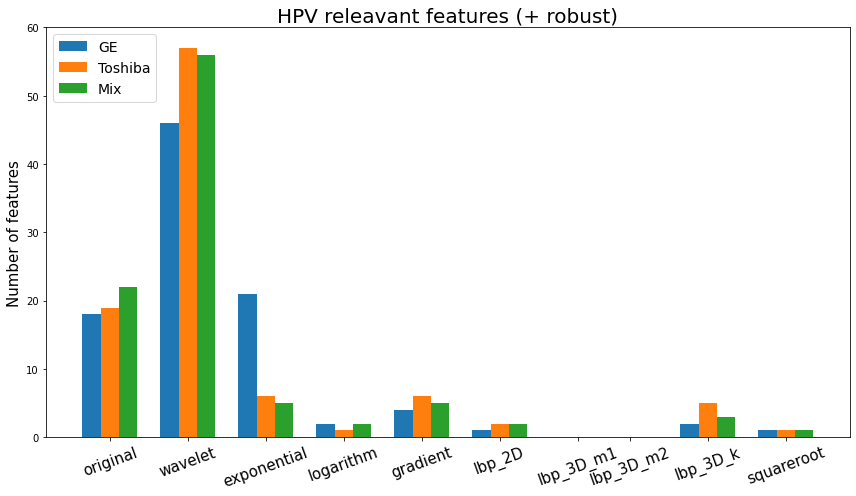

In [23]:
labels = ['original', 'wavelet', 'exponential', 'logarithm', 'gradient',
          'lbp_2D', 'lbp_3D_m1', 'lbp_3D_m2', 'lbp_3D_k', 'squareroot']

ge = filter_values(fil_g_mrmr_2)
To = filter_values(fil_t_mrmr_2)
mi = filter_values(fil_mix_mrmr_2)

x = np.array([3,6,9,12,15,18,21,23,26,29])  # the label locations
width = 2.1  # the width of the bars

fig, ax = plt.subplots(figsize = (12,7))
rects1 = ax.bar(x - width/3, ge, width/3, label='GE')
rects2 = ax.bar(x , To, width/3, label='Toshiba')
rects3 = ax.bar(x + width/3, mi, width/3, label='Mix')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of features', fontsize = 15)
ax.set_title('HPV releavant features (+ robust)',fontsize = 20)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize = 15, rotation = 20)
ax.legend(fontsize = 14, loc = 'upper left')
plt.ylim(0, 60)
fig.tight_layout()
plt.show()
# plt.savefig('/results/Figur9(Bottom).png')

In [24]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=10000)
embedded = tsne.fit_transform(df[f.loc[f['pval']<0.05, 'feat']])

xVal = embedded[:,0]
yVal = embedded[:,1]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1252 samples in 0.230s...
[t-SNE] Computed neighbors for 1252 samples in 3.420s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1252
[t-SNE] Computed conditional probabilities for sample 1252 / 1252
[t-SNE] Mean sigma: 0.834844
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.777443
[t-SNE] KL divergence after 9850 iterations: 0.991926


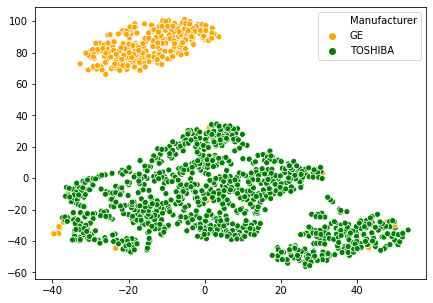

In [25]:
#Plot TSNE clusters
plt.figure(figsize=(7,5))
sns.scatterplot(x=xVal, y=yVal,hue = df['Manufacturer'],palette=['orange','green'])
ax = plt.gca()
# plt.savefig('/results/Figure4(left).png')

In [26]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=10000)
embedded = tsne.fit_transform(df[f.loc[f['pval']>0.05, 'feat']])

xVal = embedded[:,0]
yVal = embedded[:,1]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1252 samples in 0.124s...
[t-SNE] Computed neighbors for 1252 samples in 1.689s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1252
[t-SNE] Computed conditional probabilities for sample 1252 / 1252
[t-SNE] Mean sigma: 0.455677
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.817520
[t-SNE] KL divergence after 5100 iterations: 1.085078


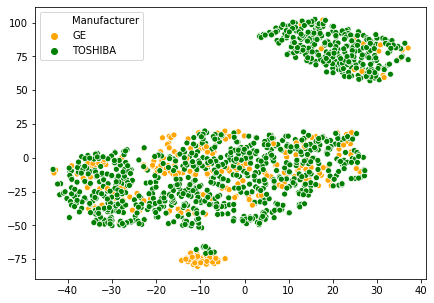

In [27]:
#Plot TSNE clusters
plt.figure(figsize=(7,5))
sns.scatterplot(x=xVal, y=yVal,hue = df['Manufacturer'],palette=['orange','green'])
ax = plt.gca()
# plt.savefig('/results/Figure4 (right).png')

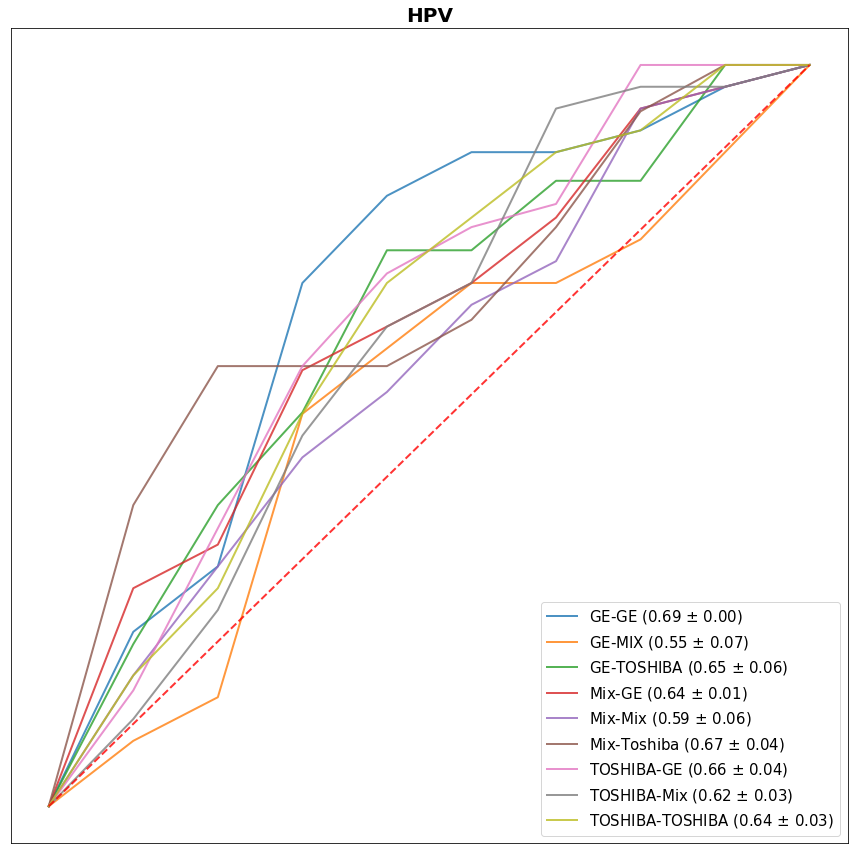

In [28]:
files =  ['ge_ge_1','ge_tosh_1','ge_mix_1','tosh_tosh_1','tosh_ge_1','tosh_mix_1','mix_mix_1','mix_tosh_1','mix_ge_1'] 
names = ['GE-GE','GE-MIX','GE-TOSHIBA','Mix-GE','Mix-Mix','Mix-Toshiba','TOSHIBA-GE','TOSHIBA-Mix','TOSHIBA-TOSHIBA']

fig, ax = plt.subplots(figsize = (15,15))

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 10)

for file,name in zip(files,names):
    mean_tpr, mean_fpr, mean_auc, std_auc ,tprs= calc_avg_values(eval(file))
    ax.plot(mean_fpr, mean_tpr,label=r'%s (%0.2f $\pm$ %0.2f)' % (name,mean_auc, std_auc),lw=2, alpha=.8)
#     std_tpr = np.std(tprs, axis=0)
#     tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
#     tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
#     ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2)
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)    
# plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xticks([])
# plt.xlabel("Flase Positive Rate", fontsize=20)
# plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.yticks([])
# plt.ylabel("True Positive Rate", fontsize=20)
plt.title('HPV', fontweight='bold', fontsize=20)
plt.legend(prop={'size':15}, loc='lower right')   
plt.show()
# plt.savefig('/results/Figur10(left).png')

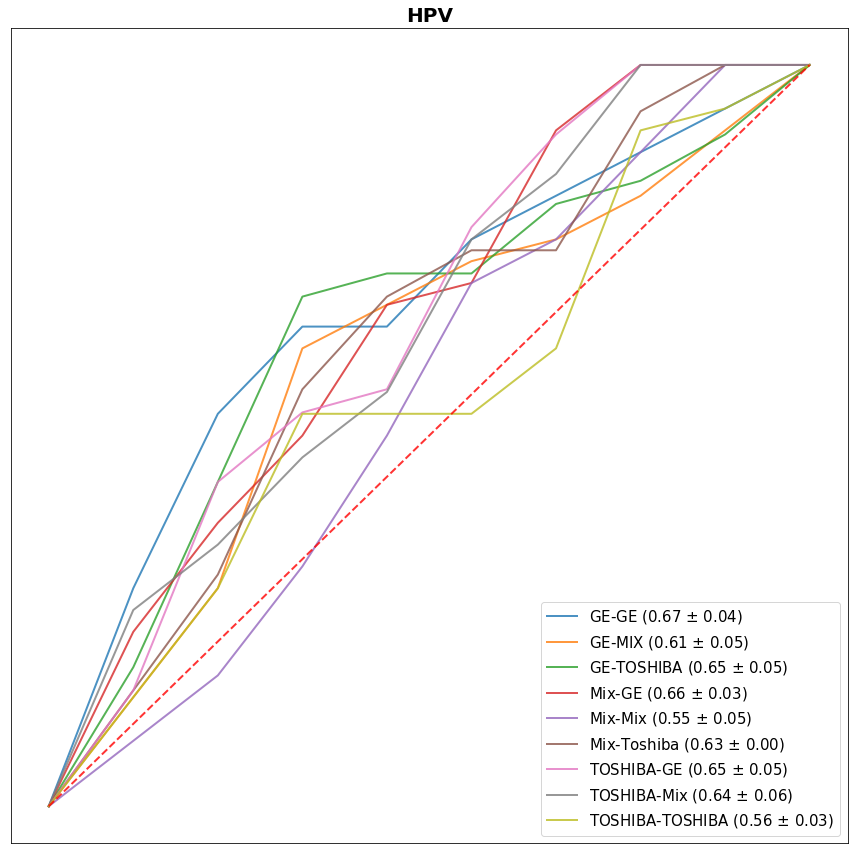

In [29]:
files =  ['ge_ge_2','ge_tosh_2','ge_mix_2','tosh_tosh_2','tosh_ge_2','tosh_mix_2','mix_mix_2','mix_tosh_2','mix_ge_2'] 
names = ['GE-GE','GE-MIX','GE-TOSHIBA','Mix-GE','Mix-Mix','Mix-Toshiba','TOSHIBA-GE','TOSHIBA-Mix','TOSHIBA-TOSHIBA']

fig, ax = plt.subplots(figsize = (15,15))

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 10)

for file,name in zip(files,names):
    mean_tpr, mean_fpr, mean_auc, std_auc ,tprs= calc_avg_values(eval(file))
    ax.plot(mean_fpr, mean_tpr,label=r'%s (%0.2f $\pm$ %0.2f)' % (name,mean_auc, std_auc),lw=2, alpha=.8)
#     std_tpr = np.std(tprs, axis=0)
#     tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
#     tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
#     ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2)
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)    
# plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xticks([])
# plt.xlabel("Flase Positive Rate", fontsize=20)
# plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.yticks([])
# plt.ylabel("True Positive Rate", fontsize=20)
plt.title('HPV', fontweight='bold', fontsize=20)
plt.legend(prop={'size':15}, loc='lower right')   
plt.show()
# plt.savefig('/results/Figur10(left).png')

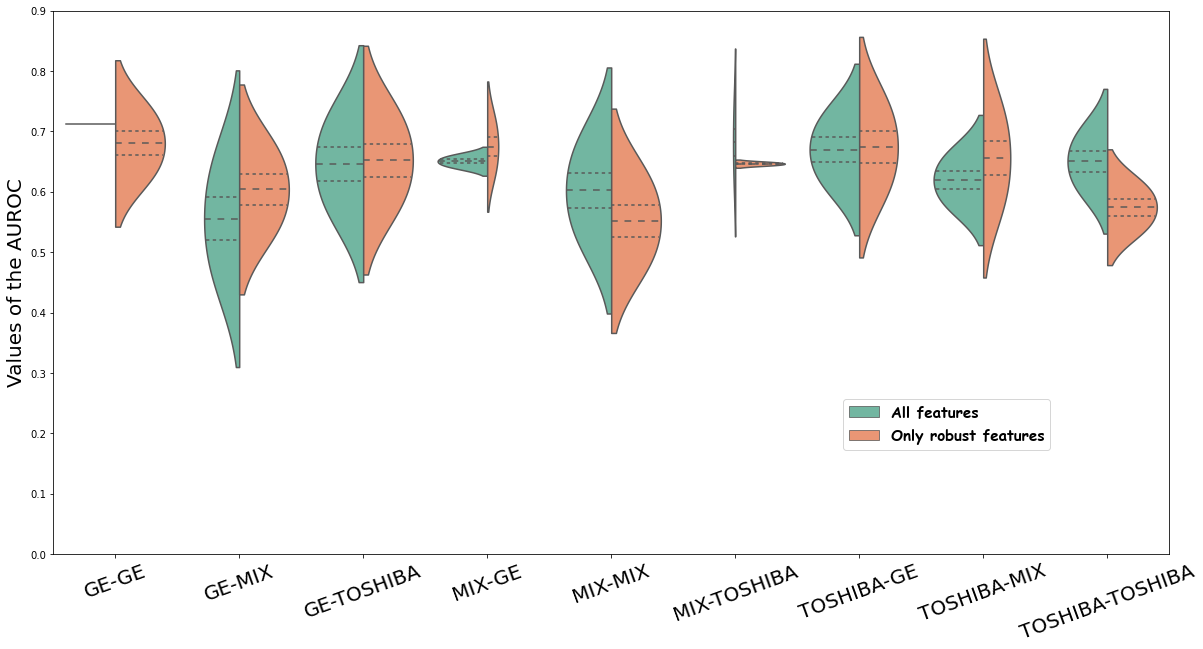

In [36]:
# inner{“box”, “quartile”, “point”, “stick”, None},
# def plotting(acc_mrmr,acc_mrmr_robust,low_rng,ylabel,x_label, inner, type1,type2):
files_1 =  ['ge_ge_1','ge_tosh_1','ge_mix_1','tosh_tosh_1','tosh_ge_1','tosh_mix_1','mix_mix_1','mix_tosh_1','mix_ge_1']
files_2 =  ['ge_ge_2','ge_tosh_2','ge_mix_2','tosh_tosh_2','tosh_ge_2','tosh_mix_2','mix_mix_2','mix_tosh_2','mix_ge_2']


plotting(make_auc(files_1),make_auc(files_2),0,'Values of the AUROC','','quartile','All features','Only robust features')
# plt.savefig('/results/Figur11.png')